<a href="https://colab.research.google.com/github/alvaroleva/TFG_collabs/blob/main/SupportVectorMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SVC classifier on imbalanced data | further study**


This script will utlimately try to find the best SVC model performing hyperparameter tunning with GridSearch on different datasets:

* **All the biomarkers**: all the 120 ECG-derived markers. 

* **Dataset 1**: best biomarkers (Correlation + Decision Trees + Univariate selection).
* **Dataset 2**: best biomarkers + clinical data.
* **Dataset 3**: 5 best biomarkers for each lead (based on Pearson correlation).
* **Dataset 4**: 5 best biomarkers for each lead (based on Pearson correlation) + clinical data. 
* **Dataset 5**: 30 best biomarkers based only on Univariate Selection (SelectKBest).
* **Dataset 6**: 30 best biomarkers based only on Tree Classifier approach.



Import needed libraries

In [ ]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Machine Learning
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score,recall_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## 0A. Import Data: all the final **biomarkers** (after KNN imputation) and **clinical** variables

> Last result from [p02_FeatureSelection_DataVisualization](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=NxjMCC3QwbGC)

In [ ]:
#Code needed to import the Data from GoogleDrive
from google.colab import files
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

X_bmkclc_url = 'https://docs.google.com/spreadsheets/d/1Md6cxfAp4_AMZlBhSHQtWj_iXljjc7o8/edit?usp=share_link&ouid=111241553451068058703&rtpof=true&sd=true'
id = X_bmkclc_url.split("/")[-2] #get ID
downloaded = drive.CreateFile({'id':id}) #download from ID
downloaded.GetContentFile('X_bmkclc.xlsx') #Get the file in the Colab working directory

#load all the merged data
X_bmkclc = pd.read_excel('X_bmkclc.xlsx', index_col = 0)
X_bmkclc = X_bmkclc.reset_index(drop=True)
print('Original dataset shape: {}'.format(X_bmkclc.shape))

Original dataset shape: (26304, 131)


## 0B. Define the custom functions to split the beats data according to BHs. 


In [ ]:
def train_test_split_BH(data_BHsymp, rnd_state, test_siz = None, figures = 1):
    """
    Performs a stratified patient partition and returns the corresponding beat selection for train and test datasets. 
    
    INPUT ARGUMENTS:
    ## Data ##
    - data_BHsymp: a pandas dataframe with all the independent variables (biomarkers), the'BH' (patient BH code) 
    and the 'symp'target variable (1: symptomatic / 0: asymptomatic). Each row correspond to a beat. 
    *Note: the 'BH' and 'symp' column names must be respected. 

    ## train_test_split parameters ##
    -rnd_state = random_state
    -strat = stratify (takes y_BH by default)
    -test_siz = percentage from 0.0 to 1.0 of patients for test. If None, by default is taken as 25%.  
   
    Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
   
    ## figures ##
    -figures = binary number indicating if pie charts are displayed (1: show / 0: hide). Showed by 
    default (figures = 1). 
    
    OUTPUT ARGUMENTS:
    -X_train = biomarkers for train (independent variables)
    -X_test  = biomarkers for test  (independent variables)
    -y_train = labels for train (target variable 'symp')
    -y_test  = labels for test  (target variable 'symp')

    *Returned in the following order X_train,X_test,y_train, y_test. 

    """
    
    #Import train_test_split from sklearn
    from sklearn.model_selection import train_test_split

    #Define a dataframe with the all the BHs and their symp condition
    BH_symp   = data_BHsymp.groupby('BH').symp.first()
    BH_symp = pd.DataFrame(BH_symp.reset_index(drop = False)) #transform it to df

    #Split the BH PATIENTS in train and test 
    X_BH = BH_symp.BH   #a pandas Series with the BH numbers.
    y_BH = BH_symp.symp #the corresponding Series with the symptomatic condition of each BH (1: sympt / 0: asympt)


    XBH_train, XBH_test, yBH_train, yBH_test = train_test_split(X_BH, y_BH, 
        random_state= rnd_state, stratify = y_BH , test_size = test_siz) #perform the split
    
    if figures:
        print('*BH patient train-test split\n---------------------------\n')
        print("Train patients: {:.2f}% | 0: {} | 1: {}".format(len(XBH_train) / len(X_BH)*100, 
                                                        yBH_train.value_counts()[0],
                                                        yBH_train.value_counts()[1]      ))

        print("Test patients:  {:.2f}% | 0: {} | 1: {}".format(len(XBH_test) / len(X_BH)*100, 
                                                        yBH_test.value_counts()[0],
                                                        yBH_test.value_counts()[1]   ))
        
        import plotly.express as px
        #See train-test overall percentage
        fig = px.pie(values= [len(XBH_train), len(XBH_test)],  names = ['Train', 'Test'], width = 400, height = 400, title = 'Train-test BH patient split')
        fig.show()


        #See symp percentages in train
        fig = px.pie(values= yBH_train.value_counts(),  names = ['Asymptomatic', 'Symptomatic'], width = 400, height = 400, title = 'TRAIN: Symptomatic vs Asymptomatic patients')
        fig.show()

        #See symp percentages in test
        fig = px.pie(values= yBH_test.value_counts(),  names = ['Asymptomatic', 'Symptomatic'], width = 400, height = 400, title = 'TEST: Symptomatic vs Asymptomatic patients')
        fig.show()
    

    #TAKE the beats corresponding to the BH train-test split
    #Select all the beats for Train
    X_train = data_BHsymp[data_BHsymp.BH.isin(XBH_train)]      #biomarkers
    y_train = data_BHsymp[data_BHsymp.BH.isin(XBH_train)].symp #labels
    #Select all the beats for Test
    X_test = data_BHsymp[data_BHsymp.BH.isin(XBH_test)]        #biomarkers
    y_test = data_BHsymp[data_BHsymp.BH.isin(XBH_test)].symp   #labels

    #Reset the indexes
    X_train = X_train.reset_index(drop = True)
    X_test  = X_test.reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)
    
    X_train_wBH_Symp = X_train.copy()
    
    #Drop the BH patient's column and symp target variable from X_train and X_test
    # and reset the indexes
    X_train = X_train.drop(columns = ['BH', 'symp']).reset_index(drop = True)
    X_test  = X_test.drop(columns =  ['BH', 'symp']).reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)
    
    return X_train,X_test,y_train, y_test, X_train_wBH_Symp

In [ ]:
def StratifiedKFold_BH (data_BHsymp, n_splits_, random_state_, shuffle_ = True):
    """
    Mimicks the behaviour of StratifiedKFold but performing the train-test splits of each fold
    according to the BH patients, and then selects the corresponding beats
    
    INPUT ARGUMENTS:
    ## Data ##
    - data_BHsymp: a pandas dataframe with all the independent variables (biomarkers), the'BH' (patient BH code) 
    and the 'symp'target variable (1: symptomatic / 0: asymptomatic). Each row correspond to a beat. 
    *Note: the 'BH' and 'symp' column names must be respected. 

    ## StratifiedKFold parameters ##
    -n_splits_ = number of folds 
    -shuffle_ = Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.
    -random_state_ = When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. 
    
    Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    
    """
    BHs_in_data = data_BHsymp.BH.unique()
    symp_in_data = data_BHsymp.groupby('BH').symp.first()

    #Perform the StratifiedKfold split of the BH patients in the 'data' dataframe
    cv = StratifiedKFold(n_splits= n_splits_, shuffle= shuffle_, random_state = random_state_)
    BH_splits = list(cv.split(BHs_in_data, symp_in_data))

    #Select the beats from that patients to define the final train-test split
    cv_beats = []
    for trainBH_index, testBH_index in BH_splits: #iterate the BH indexes for each fold

        train_BH = BHs_in_data[trainBH_index] #take the BH numbers for train
        test_BH = BHs_in_data[testBH_index]   #take the BH numbers for test

        train_data = data_BHsymp[data_BHsymp['BH'].isin(train_BH)] #take the beats of the BH patients in train
        test_data = data_BHsymp[data_BHsymp['BH'].isin(test_BH)]   #take the beats of the BH patients in test

        train_data_idx = list(train_data.index) #extract the TRAIN beat indexes and convert to list
        test_data_idx  = list(test_data.index)  #extract the TEST beat indexes and convert to list

        tuple_train_test = (train_data_idx,test_data_idx) #generate a tuple with the train-test beat indexes for each fold
        return cv_beats.append(tuple_train_test)

# **1. Define the datasets**

## **All the dataset**: All the 120 biomarkers.


In [ ]:
tot_bmk = list(X_bmkclc.columns[11:].values)
X_bmk_all = X_bmkclc[ ['BH','symp'] + tot_bmk]
print('All biomarkers shape: {}'.format(X_bmk_all.shape))

All biomarkers shape: (26304, 122)


## **Dataset 1**: best biomarkers (Correlation + Decision Trees + Univariate selection).
Includes 19 best biomarkers


In [ ]:
tot_best_bmk = ['AreaQRSabs_aVF', 'Pavg_aVL', 'LP_QRSd_V4', 'AreaQRSabs_II', 'LP_QRSd_V1', 'AreaQRSabs_V3', 'LP_RMS40_V3', 'AreaQRSabs_V2', 'Pavg_aVF', 'Pavg_III', 'ST_slope_V3', 'ST_slope_II', 'LP_QRSd_V6', 'LP_QRSd_V3', 'ST_slope_V5', 'AreaQRSabs_aVL', 'AreaQRSabs_V1', 'AreaQRSabs_III', 'QTc_V6']
X_ds1 = X_bmkclc[ ['BH','symp'] + tot_best_bmk ] 
print('Dataset 1 shape: {}'.format(X_ds1.shape))

Dataset 1 shape: (26304, 21)


## **Dataset 2**: best biomarkers + all clinical data.
Includes 19 best biomarkers + 9 clinical variables


In [ ]:
tot_best_bmk = ['AreaQRSabs_aVF', 'Pavg_aVL', 'LP_QRSd_V4', 'AreaQRSabs_II', 'LP_QRSd_V1', 'AreaQRSabs_V3', 'LP_RMS40_V3', 'AreaQRSabs_V2', 'Pavg_aVF', 'Pavg_III', 'ST_slope_V3', 'ST_slope_II', 'LP_QRSd_V6', 'LP_QRSd_V3', 'ST_slope_V5', 'AreaQRSabs_aVL', 'AreaQRSabs_V1', 'AreaQRSabs_III', 'QTc_V6']
clinical_vars = ['Diagnosis_age', 'Gender', 'Proband', 'FH_SCD', 'FH_SCD_bef_55', 'SD_VF_bef_Dg', 'sponECGtype1_all', 'AF_bef_Dg', 'EPS_inducib_dic']
X_ds2 = X_bmkclc[ ['BH','symp'] + tot_best_bmk + clinical_vars] 
print('Dataset 2 shape: {}'.format(X_ds2.shape))

Dataset 2 shape: (26304, 30)


## **Dataset 3**: 5 best biomarkers for each lead (based on correlation).
Includes 58 best biomarkers (5 from each lead but excluding 2 LP_LAS)


In [ ]:
tot_best5lead_bmk = ['PR_I', 'ST_60_I', 'ST_0_I', 'LP_QRSd_I', 'qt_I', 
'ST_0_II', 'ST_slope_II', 'PR_II', 'qt_II', 'AreaQRSabs_II',
'AreaQRSabs_III', 'Pavg_III' ,'PR_III', 'qt_III', 'LP_QRSd_III',
'ST_60_aVR', 'LP_RMS40_aVR', 'ST_0_aVR', 'PR_aVR', 'qt_aVR', 
'Pavg_aVL', 'AreaQRSabs_aVL', 'PR_aVL', 'qt_aVL', 'ST_60_aVL', 
'ST_0_aVF', 'AreaQRSabs_aVF', 'ST_slope_aVF', 'PR_aVF', 'Pavg_aVF',
'ST_60_V1', 'LP_QRSd_V1', 'PR_V1', 'qt_V1', 'AreaQRSabs_V1', 
'ST_60_V2', 'AreaQRSabs_V2', 'ST_0_V2', 'PR_V2', 'LP_QRSd_V2',
'ST_60_V3', 'LP_QRSd_V3', 'PR_V3', 'AreaQRSabs_V3', 'LP_RMS40_V3',
'LP_QRSd_V4', 'ST_60_V4', 'ST_0_V4', 'qt_V4',
'ST_slope_V5', 'ST_0_V5', 'qt_V5', 'QTc_V5','PR_V5',
'QTc_V6', 'LP_QRSd_V6', 'qt_V6', 'ST_slope_V6' ]

X_ds3 = X_bmkclc[ ['BH','symp'] + tot_best5lead_bmk ] 
print('Dataset 3 shape: {}'.format(X_ds3.shape))

Dataset 3 shape: (26304, 60)


## **Dataset 4**: 5 best biomarkers for each lead (based on correlation) + clinical data.
Includes 58 best biomarkers (5 from each lead but excluding 2 LP_LAS) + clinical data. 


In [ ]:
X_ds4 = X_bmkclc[ ['BH','symp'] + tot_best5lead_bmk +  clinical_vars] 
print('Dataset 3 shape: {}'.format(X_ds4.shape))

Dataset 3 shape: (26304, 69)


## **Dataset 5**: best biomarkers and clinical variable based on univariate selection (SelectKBest).
Repeat what it was done in [3.2.3 Univariate selection](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=_cHtUC3zwbxo) but now taken into account also the clinical data. 

Includes the **30 best features** including both biomarkers and clinical data. 


In [ ]:
#UNIVARIATE SELECTION
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_features = X_bmkclc.drop(columns = ['BH','symp'] )
y_symp = X_bmkclc.symp

bestfeatures = SelectKBest(score_func = f_classif, k = 10)
fit = bestfeatures.fit(abs(X_features),y_symp)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_features.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print(featureScores.nlargest(30,'Score'))
best_30ft_univ = featureScores.nlargest(30,'Score').Features
best_30ft_univ = list(best_30ft_univ)

#Dataframe ´
X_ds5 = X_bmkclc[ ['BH','symp'] + best_30ft_univ ] 
print('Dataset 5 shape: {}'.format(X_ds5.shape))

            Features          Score
7          AF_bef_Dg  243682.649512
4      FH_SCD_bef_55  224545.368780
30    AreaQRSabs_III   26852.344773
108      LP_RMS40_V4   21700.739984
50    AreaQRSabs_aVL   19295.071599
60    AreaQRSabs_aVF   14314.328154
48      LP_RMS40_aVR   13788.979823
97        LP_QRSd_V3   12337.993197
77        LP_QRSd_V1   11438.236756
107       LP_QRSd_V4   10100.602778
98       LP_RMS40_V3    9195.398490
128      LP_RMS40_V6    8785.564600
80     AreaQRSabs_V2    8749.083805
90     AreaQRSabs_V3    8683.202775
122           QTc_V6    7457.869101
112           QTc_V5    6489.405613
8    EPS_inducib_dic    6017.478399
5       SD_VF_bef_Dg    5590.421864
127       LP_QRSd_V6    5391.176784
88       LP_RMS40_V2    5230.148456
38      LP_RMS40_III    5203.401951
87        LP_QRSd_V2    5128.914406
20     AreaQRSabs_II    4987.228065
70     AreaQRSabs_V1    3911.473530
92            QTc_V3    3878.660452
102           QTc_V4    3273.753943
62           QTc_aVF    3172

## **Dataset 6**: best biomarkers based only on Tree Classifier approach

Repeat what it was done in [3.2.2 Tree Classifier approach](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=_cHtUC3zwbxo) but now taken into account also the clinical data. 

Includes the **30 best features** including both biomarkers and clinical data. 


In [ ]:
#Tree Classifier 
from sklearn.ensemble import ExtraTreesClassifier
feature_importances = []

n_trials = 3
for i in range(n_trials):
    model = ExtraTreesClassifier(random_state= i )
    model.fit(X_features, y_symp) #the same inputs as before
    feature_importances.append(model.feature_importances_)

# Aggregate feature importances for each trial
average_importances = np.mean(feature_importances, axis=0)
feat_importances = pd.Series(average_importances, index=X_features.columns)

# Select the top 30 features
best_30ft_tree = list(feat_importances.nlargest(30).index)

#Dataframe ´
X_ds6 = X_bmkclc[ ['BH','symp'] + best_30ft_tree ] 
print('Dataset 6 shape: {}'.format(X_ds6.shape))


Dataset 6 shape: (26304, 32)


In [ ]:
best_30ft_tree

['SD_VF_bef_Dg',
 'FH_SCD_bef_55',
 'AF_bef_Dg',
 'Diagnosis_age',
 'sponECGtype1_all',
 'EPS_inducib_dic',
 'Gender',
 'FH_SCD',
 'Pavg_aVL',
 'PR_V5',
 'ST_0_I',
 'AreaQRSabs_aVL',
 'AreaQRSabs_III',
 'Pavg_II',
 'Proband',
 'Pavg_aVF',
 'LP_QRSd_V4',
 'Pavg_III',
 'PR_V6',
 'ST_60_aVR',
 'LP_QRSd_V6',
 'AreaQRSabs_V2',
 'AreaQRSabs_aVF',
 'LP_QRSd_V3',
 'ST_slope_I',
 'LP_QRSd_aVL',
 'LP_QRSd_I',
 'ST_60_V3',
 'PR_II',
 'ST_slope_V5']

> Perform the feature selection based on ``ExtraTreesClassifier`` but modifing 3 times the ``random_state`` to ensure more robustneess. It end up with the 30 common features that have an average better importance on the 3 randomizations.

**For better readability a dictionary will be done containing the 6 datasets.**

In [ ]:
all_datasets = {'All_biomarkers': X_bmk_all,'Dataset_1': X_ds1,'Dataset_2': X_ds2, 'Dataset_3': X_ds3,'Dataset_4': X_ds4, 'Dataset_5': X_ds5, 'Dataset_6':X_ds6}

# **2. Find the best SVC model**
The same process will be conducted over each dataset.

### **1. First try SVC with default parameters**



In [ ]:
default_results_ds = [];
for dataset_name, dataset in all_datasets.items():
  print(dataset_name)

  #A. Define the X,y
  X = dataset.drop(columns = ['BH', 'symp'])
  y = dataset.symp

  X_wBH_Symp = dataset #needed input for StratifiedKFold_BH (in this case corresponds to the raw datasets)

 
    #Define the model
  model = SVC() 

    #B.3 Cross validation score with all data to assess the performance of the model for each dataset
  n_scores = []
  n_trials = 3
  for i in range(n_trials):
    #define the cross-validation strategy to validate the model (using the custom function)
    cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

    #evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    #save the mean scores
    n_scores.append(np.mean(scores))
    mean_cv_nscore = np.mean(n_scores)

    #Save RESULTS: The mean ROC_AUC cv score for each dataset
  default_results_ds.append({
      'Dataset' : dataset_name,
      'AUC_roc_mean_cvscore': mean_cv_nscore
      
  })

df_DatasetResults = pd.DataFrame(default_results_ds,columns=['Dataset', 'AUC_roc_mean_cvscore'])

All_biomarkers
Dataset_1
Dataset_2
Dataset_3
Dataset_4
Dataset_5
Dataset_6


In [ ]:
df_DatasetResults

,Dataset,AUC_roc_mean_cvscore
0,All_biomarkers,0.455665
1,Dataset_1,0.515284
2,Dataset_2,0.566571
3,Dataset_3,0.525293
4,Dataset_4,0.573653
5,Dataset_5,0.494711
6,Dataset_6,0.550223


#### Test prediction with **default SVC** and **Dataset 6**. I am also interested in trying **Dataset 1**: only the 19 best biomarkers without clinical data. The following scrit compute the sensitivity and AUC for 4 random test-train partitions. 

In [ ]:
ds_2try = {'Dataset 6': X_ds6,  'Dataset 1': X_ds1}

In [ ]:
results_ds2try = []
for ds2try_name, ds2try in ds_2try.items():
  print(ds2try_name)
  n_trials = 4
  mean_sensitivity = []
  mean_AUC = []
  for i in range(n_trials):
    X_train, X_test, y_train, y_test, X_train_wBH_Symp = train_test_split_BH(ds2try, rnd_state = i, figures = 0)
    model = SVC() 
    model.fit(X_train, y_train) #training
    y_pred = model.predict(X_test) #predictions
    #confusion matrix
    labels_str= [0,1]
    cm = confusion_matrix(y_test, y_pred, labels= labels_str)
    tn, fp, fn, tp = cm.ravel()

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    AUC = roc_auc_score(y_test,y_pred)
    mean_sensitivity.append(sensitivity)
    mean_AUC.append(AUC)

  #Save RESULTS: The mean ROC_AUC cv score for each dataset
  results_ds2try.append({
    'Dataset' : ds2try_name,
    'Sensitivity_mean': np.mean(mean_sensitivity),
    'AUC_roc_mean': np.mean(mean_AUC)
    
  })

results_ds2try

Dataset 6
Dataset 1


[{'Dataset': 'Dataset 6',
  'Sensitivity_mean': 0.010308319892593083,
  'AUC_roc_mean': 0.45660538377455645},
 {'Dataset': 'Dataset 1',
  'Sensitivity_mean': 0.0013241525423728813,
  'AUC_roc_mean': 0.4955511046811836}]

In [ ]:
df_results_ds2try = pd.DataFrame(results_ds2try,columns=['Dataset', 'Sensitivity_mean', 'AUC_roc_mean'])
df_results_ds2try

,Dataset,Sensitivity_mean,AUC_roc_mean
0,Dataset 6,0.078050,0.421871
1,Dataset 1,0.192187,0.458948


To see if the biomarkers without clinical data can classify, let's take **Dataset 1**

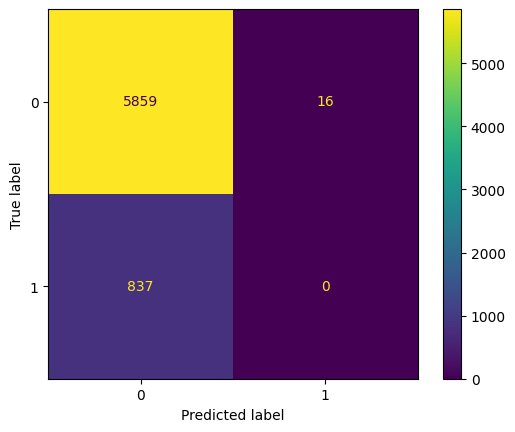

Accuracy:  0.8729141835518475
AUC roc:  0.49863829787234043
Sensitivity: 0.000 %
Specificity: 99.728 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.88      1.00      0.93      5875
 Symptomatic (1)       0.00      0.00      0.00       837

        accuracy                           0.87      6712
       macro avg       0.44      0.50      0.47      6712
    weighted avg       0.77      0.87      0.82      6712



In [ ]:
X_train, X_test, y_train, y_test, X_train_wBH_Symp = train_test_split_BH(X_ds1, rnd_state = 0, figures = 0)

model = SVC() 
model.fit(X_train, y_train) #training
y_pred = model.predict(X_test) #predictions


#confusion matrix
labels_str= [0,1]

cm = confusion_matrix(y_test, y_pred, labels= labels_str)
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_str)
cm_fig.plot()

plt.show()

tn, fp, fn, tp = cm.ravel()

# compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('AUC roc: ' , roc_auc_score(y_test,y_pred))
print('Sensitivity: {:.3f} %'.format(sensitivity*100))
print('Specificity: {:.3f} %'.format(specificity*100))

target_names = ['Asymptomatic (0)', 'Symptomatic (1)']
print(classification_report(y_test, y_pred, target_names=target_names))


### **2. Secondly try weighted SVC**

To improve the performance of Support Vector Machines (SVM) models, each example in the training dataset is assigned its own penalty term (C value) which is used to calculate the margin. This C value can be calculated as a weighted version of the global C value, where the weight is proportional to the class distribution. When an example is misclassified, the penalty for the mistake is greater if its weight is small and vice versa.

The ``class_weight``argument of SVC is a hyperparameter that allows the user to specify a dictionary defining the weighting for each class label in the calculation of the soft margin. A good practice is to use the inverse of the class distribution in the training dataset as the class weighting. 

In the case of our dataset, if the minority class has a **15:100** ratio to the majority class, **the class weighting can be set to 1.5 for the majority class and 100 for the minority class**.

By defining ``class_weight = 'balanced'`` the weight is automatically adapted to the distribution of our imbalanced data.  


> https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/



In [ ]:
weighted_results_ds = [];
for dataset_name, dataset in all_datasets.items():
  print(dataset_name)

  #A. Define the X,y
  X = dataset.drop(columns = ['BH', 'symp'])
  y = dataset.symp

  X_wBH_Symp = dataset #needed input for StratifiedKFold_BH (in this case corresponds to the raw datasets)

 
    #Define the model
  model = SVC(class_weight= 'balanced') 

    #B.3 Cross validation score with all data to assess the performance of the model for each dataset
  n_scores = []
  n_trials = 3
  for i in range(n_trials):
    #define the cross-validation strategy to validate the model (using the custom function)
    cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

    #evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    #save the mean scores
    n_scores.append(np.mean(scores))
    mean_cv_nscore = np.mean(n_scores)

    #Save RESULTS: The mean ROC_AUC cv score for each dataset
  weighted_results_ds.append({
      'Dataset' : dataset_name,
      'AUC_roc_mean_cvscore': mean_cv_nscore
      
  })

df_DatasetResults = pd.DataFrame(weighted_results_ds,columns=['Dataset', 'AUC_roc_mean_cvscore'])

All_biomarkers
Dataset_1
Dataset_2
Dataset_3
Dataset_4
Dataset_5
Dataset_6


In [ ]:
df_DatasetResults

,Dataset,AUC_roc_mean_cvscore
0,All_biomarkers,0.475525
1,Dataset_1,0.539955
2,Dataset_2,0.573405
3,Dataset_3,0.537263
4,Dataset_4,0.582990
5,Dataset_5,0.537695
6,Dataset_6,0.551558


Similar AUC values for weighted SVC but let's compare the confusion matrix of **Dataset 1**. 

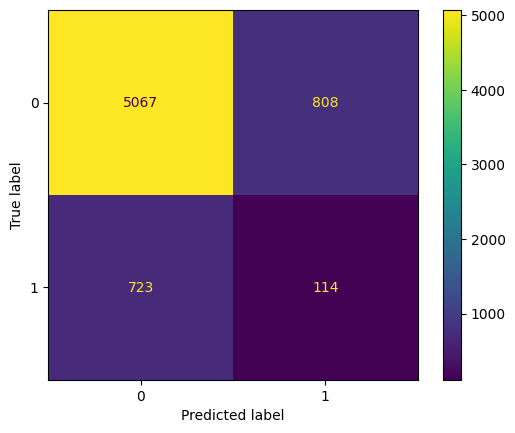

Accuracy:  0.7719010727056019
AUC roc:  0.4993344009761305
Sensitivity: 13.620 %
Specificity: 86.247 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.88      0.86      0.87      5875
 Symptomatic (1)       0.12      0.14      0.13       837

        accuracy                           0.77      6712
       macro avg       0.50      0.50      0.50      6712
    weighted avg       0.78      0.77      0.78      6712



In [ ]:
X_train, X_test, y_train, y_test, X_train_wBH_Symp = train_test_split_BH(X_ds1, rnd_state = 0, figures = 0)

model = SVC(class_weight= 'balanced') 
model.fit(X_train, y_train) #training
y_pred = model.predict(X_test) #predictions


#confusion matrix
labels_str= [0,1]

cm = confusion_matrix(y_test, y_pred, labels= labels_str)
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_str)
cm_fig.plot()

plt.show()

tn, fp, fn, tp = cm.ravel()

# compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('AUC roc: ' , roc_auc_score(y_test,y_pred))
print('Sensitivity: {:.3f} %'.format(sensitivity*100))
print('Specificity: {:.3f} %'.format(specificity*100))

target_names = ['Asymptomatic (0)', 'Symptomatic (1)']
print(classification_report(y_test, y_pred, target_names=target_names))


In [ ]:
#Assess the default SVM performance for each subset
default_results_subsets = [];
for subset_name, subset in X_ds6_subsets.items():
  print(subset_name)
  #A. Define the X,y
  X = subset.drop(columns = ['BH', 'symp'])
  y = subset.symp

  X_wBH_Symp = subset #needed input for StratifiedKFold_BH (in this case corresponds to the raw subsets)

 
    #Define the model
  model = SVC(class_weight= 'balanced') 

    #B.3 Cross validation score with all data to assess the performance of the model for each subset
  n_scores = []
  n_trials = 5
  for i in range(n_trials):
    #define the cross-validation strategy to validate the model (using the custom function)
    cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

    #evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    #save the mean scores
    n_scores.append(np.mean(scores))
    mean_cv_nscore = np.mean(n_scores)

    #Save RESULTS: The mean ROC_AUC cv score for each subset
  default_results_subsets.append({
      'Subset' : subset_name,
      'AUC_roc_mean_cvscore': mean_cv_nscore
      
  })

df_SubsetResults = pd.DataFrame(default_results_subsets,columns=['Subset', 'AUC_roc_mean_cvscore'])

Subset_10
Subset_20
Subset_30
Subset_40
Subset_50
Subset_60


In [ ]:
df_SubsetResults

,Subset,AUC_roc_mean_cvscore
0,Subset_10,0.370177
1,Subset_20,0.584572
2,Subset_30,0.551558
3,Subset_40,0.589260
4,Subset_50,0.599785
5,Subset_60,0.574623


In [ ]:
results_nft_subsets = []
for subset_name, subset in X_ds6_subsets.items():
  print(subset_name)
  n_trials = 4
  mean_sensitivity = []
  mean_AUC = []
  for i in range(n_trials):
    X_train, X_test, y_train, y_test, X_train_wBH_Symp = train_test_split_BH(subset, rnd_state = i, figures = 0)
    model = SVC(class_weight= 'balanced') 
    model.fit(X_train, y_train) #training
    y_pred = model.predict(X_test) #predictions
    #confusion matrix
    labels_str= [0,1]
    cm = confusion_matrix(y_test, y_pred, labels= labels_str)
    tn, fp, fn, tp = cm.ravel()

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    AUC = roc_auc_score(y_test,y_pred)
    mean_sensitivity.append(sensitivity)
    mean_AUC.append(AUC)

  #Save RESULTS: The mean ROC_AUC cv score for each dataset
  results_nft_subsets.append({
    'Subset' : subset_name,
    'Sensitivity_mean': np.mean(mean_sensitivity),
    'AUC_roc_mean': np.mean(mean_AUC)
    
  })

df_nft_subset = pd.DataFrame(results_nft_subsets,columns=['Subset', 'Sensitivity_mean', 'AUC_roc_mean'])

Subset_10
Subset_20
Subset_30
Subset_40
Subset_50
Subset_60


In [ ]:
df_nft_subset

,Subset,Sensitivity_mean,AUC_roc_mean
0,Subset_10,0.348560,0.468315
1,Subset_20,0.183867,0.441091
2,Subset_30,0.078050,0.421871
3,Subset_40,0.063438,0.431933
4,Subset_50,0.061619,0.448447
5,Subset_60,0.197294,0.493630


As the top 10 features contain mainly clinical variables this make us think that could be the reason of obtaining the best sensitivity. 

### **2. GridSearchCV hyperparameter tunning with the best biomarkers**
In an imbalanced dataset, it's important to ensure that the proportion of the minority class is maintained in the training and testing sets. This can be achieved with the stratify parameter of the train_test_split() function. Morover Stratified K-fold will be used and the score function in GridSearchSV will be de auc_roc (f-score is also valid).

In [ ]:
best_ds = X_ds1

TRAIN-TEST split

In [ ]:
X_train, X_test, y_train, y_test, X_train_wBH_Symp = train_test_split_BH(best_ds, rnd_state = 0, figures = 0)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print('\n')
print('TRAIN: Symptomatic vs Asymptomatic beat count')
print(y_train.value_counts())
print('\n')
print('TEST:  Symptomatic vs Asymptomatic beat count')
print(y_test.value_counts())

X_train shape: (19592, 19)
y_train shape: (19592,)
X_test shape: (6712, 19)
y_test shape: (6712,)


TRAIN: Symptomatic vs Asymptomatic beat count
0    16340
1     3252
Name: symp, dtype: int64


TEST:  Symptomatic vs Asymptomatic beat count
0    5875
1     837
Name: symp, dtype: int64


In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {
          "C": [0.01, 0.1, 10, 100],
          "gamma": [0.1, 0.001, 1],
          }


#Define the weighted model
SVC = SVC(class_weight = 'balanced')
# Loop for each trial
num_trials = 3
non_nested_scores = np.zeros(num_trials)# Array to store scores
for i in range(num_trials):

    # Selecting stratified cross-validation technique for preserving the data distribution
    outer_cv = StratifiedKFold_BH (X_train_wBH_Symp, n_splits_ = 4, random_state_ = i, shuffle_ = True)#define the outer loop with 4folds 

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator= SVC, param_grid=p_grid, cv=outer_cv, scoring = 'roc_auc')
    print('Hyperparameter tunning has started | Waiting for the results...')
    clf.fit(X_train, y_train) #DO IT WITH TRAIN 
    print('Hyperparameter tunning has finished | Saving the results...')
    
    #Results
    non_nested_scores[i] = clf.best_score_

    #Save results
    best_params = clf.best_params_
    best_estimator = clf.best_estimator_
    results = clf.cv_results_
    print(best_params)
    print(best_estimator)

    # Export GridSearchCV results into a dataframe for better view
    df_results = pd.DataFrame(results)

    # #Download results in local 
    # from google.colab import files

    # df_results.to_excel('XGB_GridSearch{}.xlsx'.format(i))
    # # download the file to your local PC
    # files.download('XGB_GridSearch{}.xlsx'.format(i))

### **Final cross-validation**

In [ ]:
best_ds = X_ds1
best_model = SVC(class_weight = 'balanced', C = 0.125, kernel = 'rbf', gamma = 0.001)

#A. Define the X,y
X = best_ds.drop(columns = ['BH', 'symp'])
y = best_ds.symp

X_wBH_Symp = best_ds #needed input for StratifiedKFold_BH (in this case corresponds to the raw datasets)

#Cross validation score with all data to assess the performance of the model for each dataset
mean_cv_AUC = []
mean_cv_recall = []
mean_cv_specificity = []

n_trials = 3
for i in range(n_trials):
  #define the cross-validation strategy to validate the model (using the custom function)
  cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

  #evaluate the model
  cv_AUCs = cross_val_score(best_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
  cv_recalls = cross_val_score(best_model, X, y, scoring='recall', cv=cv, n_jobs=-1)  
  #save the mean scores
  mean_cv_AUC.append(np.mean(cv_AUCs))
  mean_cv_recall.append(np.mean(cv_recalls))

print(np.mean(mean_cv_AUC))
print(np.mean(mean_cv_recall))


0.7075602481748561
0.27222440019990846


#### Extra test: Leave-one-patient-out approach
In each iteration we'll train the model taking only one patient appart to test. 

One-Single model


In [ ]:
def leave_one_out_pred(dataset,model):
  pred_symp_percentages = []

  BHs = dataset.BH.unique()
  BHs = list(BHs) #convert BHs to list

  for n_pat in range(len(BHs)):
    print('Progress: {:.2f}%'.format(n_pat/64*100))

    #Take one patient as test and the rest for train
    test_BH = BHs[n_pat]
    train_BH = BHs[:n_pat] + BHs[n_pat+1:]

    #Select all the beats for Train
    X_train = dataset[dataset.BH.isin(train_BH)]      #biomarkers
    y_train = dataset[dataset.BH.isin(train_BH)].symp #labels


    #Select all the beats for Test
    X_test = dataset[dataset.BH == test_BH]        #biomarkers
    y_test = dataset[dataset.BH == test_BH].symp   #labels

    #Reset the indexes
    X_train = X_train.reset_index(drop = True)
    X_test  = X_test.reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)


    #Drop the BH patient's column and symp target variable from X_train and X_test
    # and reset the indexes
    X_train = X_train.drop(columns = ['BH', 'symp']).reset_index(drop = True)
    X_test  = X_test.drop(columns =  ['BH', 'symp']).reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)


    #DEFINE XGBoost MODELS
    #Compute scale_pos_weight value
    counter = Counter(y_train) # count samples in each class
    weight = counter[0] / counter[1]

    model.fit(X_train, y_train) #training
    y_pred_BH = model.predict(X_test) #predictions

    pred_counter = Counter(y_pred_BH)

    if pred_counter[0] == 0:
      pred_symp_percentage = 0
    else:
      pred_symp_percentage = pred_counter[1]/(pred_counter[0] + pred_counter[1])*100
    pred_symp_percentages.append(pred_symp_percentage)
  
  return pred_symp_percentages

In [ ]:
SVC_m1 = SVC(class_weight = 'balanced', C = 10)
SVC_m2 = SVC(class_weight = 'balanced', C = 0.1)
SVC_m3 = SVC(class_weight = 'balanced', C = 0.01)
SVC_m4 =  SVC(class_weight = 'balanced', C = 0.001)

SVC_models = {'Model_1' : SVC_m1, 'Model_2': SVC_m2, 'Model_3': SVC_m3, 'Model_4': SVC_m4} #dictionary with all the models to try

model_results = [];
for model_name, model in SVC_models.items():
  print(model_name)
  y_pred = leave_one_out_pred(best_ds, model)
  model_results.append({model_name : y_pred})

Model_1
Progress: 0.00%
Progress: 1.56%
Progress: 3.12%
Progress: 4.69%
Progress: 6.25%
Progress: 7.81%
Progress: 9.38%
Progress: 10.94%
Progress: 12.50%
Progress: 14.06%
Progress: 15.62%
Progress: 17.19%
Progress: 18.75%
Progress: 20.31%
Progress: 21.88%
Progress: 23.44%
Progress: 25.00%
Progress: 26.56%
Progress: 28.12%
Progress: 29.69%
Progress: 31.25%
Progress: 32.81%
Progress: 34.38%
Progress: 35.94%
Progress: 37.50%
Progress: 39.06%
Progress: 40.62%
Progress: 42.19%
Progress: 43.75%
Progress: 45.31%
Progress: 46.88%
Progress: 48.44%
Progress: 50.00%
Progress: 51.56%
Progress: 53.12%
Progress: 54.69%
Progress: 56.25%
Progress: 57.81%
Progress: 59.38%
Progress: 60.94%
Progress: 62.50%
Progress: 64.06%
Progress: 65.62%
Progress: 67.19%
Progress: 68.75%
Progress: 70.31%
Progress: 71.88%
Progress: 73.44%
Progress: 75.00%
Progress: 76.56%
Progress: 78.12%
Progress: 79.69%
Progress: 81.25%
Progress: 82.81%
Progress: 84.38%
Progress: 85.94%
Progress: 87.50%
Progress: 89.06%
Progress: 90.

In [ ]:
m1,m2,m3,m4 = model_results
df_model_results = pd.concat([pd.DataFrame(m1), pd.DataFrame(m2), pd.DataFrame(m3), pd.DataFrame(m4)], axis = 1)
df_BHs = pd.DataFrame(best_ds.BH.unique(), columns = ['BH'])
df_symp_real = best_ds.groupby('BH').symp.first()
df_model_results = pd.concat([df_BHs, df_model_results, df_symp_real.reset_index(drop = True)], axis = 1)
df_model_results.round(2)


#Download results in local 
from google.colab import files

df_model_results.to_excel('SVC_leaveOneOut_ypred.xlsx')
# download the file to your local PC
files.download('SVC_leaveOneOut_ypred.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_model_results #in percentage

,BH,Model_1,Model_2,Model_3,Model_4,symp
0,1,10.473815,2.244389,1.745636,0.249377,0
1,2,18.518519,20.138889,21.759259,13.194444,0
2,3,4.047619,32.142857,45.000000,1.428571,1
3,4,0.000000,0.000000,0.000000,0.000000,0
4,5,7.317073,23.503326,26.385809,4.212860,0
...,...,...,...,...,...,...
59,105,59.423503,50.776053,12.416851,1.552106,0
60,106,15.217391,52.173913,46.135266,7.004831,0
61,107,16.509434,11.320755,4.245283,3.066038,0
62,108,9.052632,0.000000,0.000000,0.000000,0


In [ ]:
y_pred_models = df_model_results.iloc[:,1:5] >= 50 
y_pred_models = y_pred_models.astype(int)
y_pred_models

,Model_1,Model_2,Model_3,Model_4
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
59,1,1,0,0
60,0,1,0,0
61,0,0,0,0
62,0,0,0,0


Model_1
------------------------------------



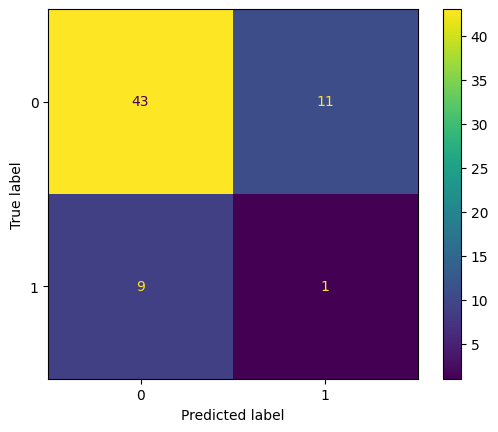

AUC roc:  0.4481481481481482
Sensitivity: 10.000 %
Specificity: 79.630 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.83      0.80      0.81        54
 Symptomatic (1)       0.08      0.10      0.09        10

        accuracy                           0.69        64
       macro avg       0.46      0.45      0.45        64
    weighted avg       0.71      0.69      0.70        64

Model_2
------------------------------------



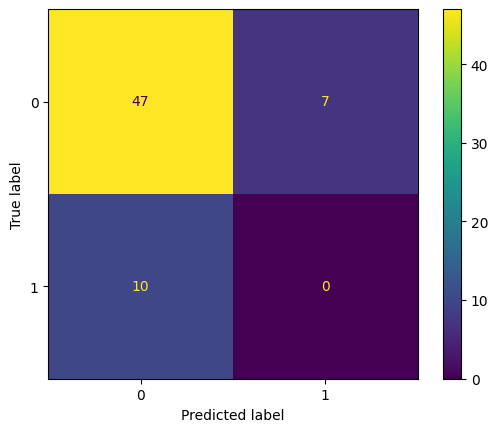

AUC roc:  0.4351851851851852
Sensitivity: 0.000 %
Specificity: 87.037 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.82      0.87      0.85        54
 Symptomatic (1)       0.00      0.00      0.00        10

        accuracy                           0.73        64
       macro avg       0.41      0.44      0.42        64
    weighted avg       0.70      0.73      0.71        64

Model_3
------------------------------------



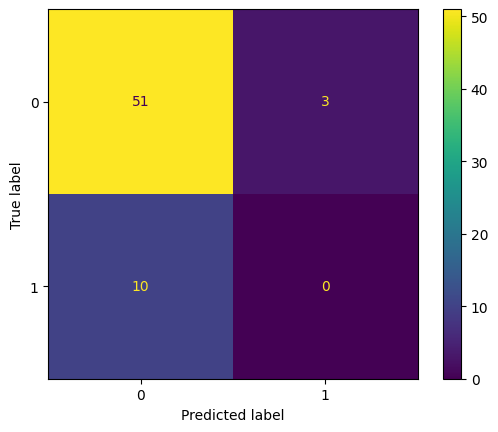

AUC roc:  0.4722222222222222
Sensitivity: 0.000 %
Specificity: 94.444 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.84      0.94      0.89        54
 Symptomatic (1)       0.00      0.00      0.00        10

        accuracy                           0.80        64
       macro avg       0.42      0.47      0.44        64
    weighted avg       0.71      0.80      0.75        64

Model_4
------------------------------------



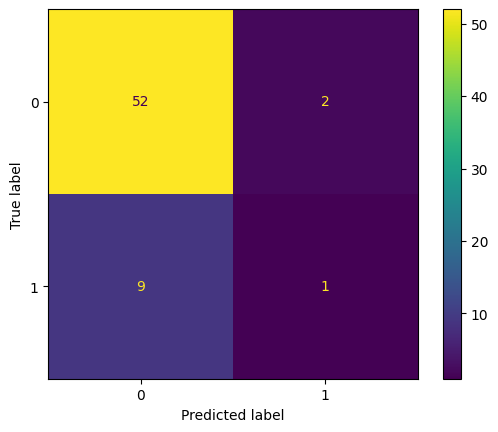

AUC roc:  0.5314814814814816
Sensitivity: 10.000 %
Specificity: 96.296 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.85      0.96      0.90        54
 Symptomatic (1)       0.33      0.10      0.15        10

        accuracy                           0.83        64
       macro avg       0.59      0.53      0.53        64
    weighted avg       0.77      0.83      0.79        64



In [ ]:
for model in y_pred_models.columns:
  print(model)
  print('------------------------------------\n')
  y_pred = y_pred_models[model].values
  y_real = df_model_results.symp
  #confusion matrix
  labels_str= [0,1]

  cm = confusion_matrix(y_real, y_pred, labels= labels_str)
  cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=labels_str)
  cm_fig.plot()

  plt.show()

  tn, fp, fn, tp = cm.ravel()

  # compute sensitivity and specificity
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print('AUC roc: ' , roc_auc_score(y_real,y_pred))
  print('Sensitivity: {:.3f} %'.format(sensitivity*100))
  print('Specificity: {:.3f} %'.format(specificity*100))

  target_names = ['Asymptomatic (0)', 'Symptomatic (1)']
  print(classification_report(y_real, y_pred, target_names=target_names))
